# IMPORTS

In [3]:
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt
import skimage.io as io

# SEGMENTATION FUNCTIONS

### STAFF SEGMENTATION

In [4]:
def segment_staff(img):
    #Takes a Uint8 grey image and returns an array of images of staffs
    #Only works on Non-rotated images
    inverted_img = (255 - img) / 255

    #Dilate the image

    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT,(80,6)) #Should check for better structuring elements
    dilated_img = cv2.dilate(inverted_img,struct_element,iterations=5)
    # debug_show_images([dilated_img]) #print dilated image

    #Calculate the Horizontal histogram
    hist_hor = np.sum(dilated_img,axis=1)
    # plt.plot(hist_hor)
    # plt.hlines(threshold,-50,len(hist_hor)+50,colors="0.5",linestyles="dashed")
    # plt.show()


    #Calculate the threshold of Segmentation
    # Try every different values of thresholds and choose the one that has lowest sigma and wider average distance
    sorted_hist_hor = sorted(hist_hor)
    percentage_taken = 0.03
    iteration_values = []
    for iteration in range(1,31) :

        #Calculate the Threshold with a different ratio everytime
        current_max_len = int( len(sorted_hist_hor) * percentage_taken * iteration)
        averaged_partition = sorted_hist_hor[0:current_max_len] # Percentage Average Taken
        threshold = round(np.average(averaged_partition))

        #calculate the width of the segments using the current threshold
        start_cut = 0
        staff_width = []
        less_flag = 0
        for i in range(len(hist_hor)):
            if less_flag == 0 and hist_hor[i] < threshold:
                less_flag = 1
            elif less_flag == 1 and hist_hor[i] > threshold:
                start_cut = i
                less_flag = 2
            elif less_flag == 2 and hist_hor[i] < threshold:
                staff_width.append( i-start_cut )
                less_flag = 0

        # If there was atleast one segment we add them to be compared later 
        if len(staff_width) > 0:
            sigma = np.std(staff_width)
            average_width = np.average(staff_width)
            iteration_values.append( (sigma,average_width,len(staff_width),threshold) )

    #Criteria for a good minimum sigma
    all_sigmas = [itr[0]for itr in iteration_values]
    min_sigma = 3 if np.median(all_sigmas) <= 3 else np.median(all_sigmas)


    #Initial value and base case if no segments found
    best_iteration = (0,0,0,0)
    max_segments = 0

    #Comparing between the sigmas and average width found in the above loop to find the best threshold
    for iteration in iteration_values:
        if iteration[0] < min_sigma and iteration[2] > max_segments:
            max_segments = iteration[2]
            best_iteration = iteration
        elif iteration[0] < min_sigma and iteration[1] > best_iteration[1]:
            best_iteration = iteration

    #Find the boundaries with best threshold
    threshold = best_iteration[3]
    # plt.plot(hist_hor)
    # plt.hlines(threshold,-50,len(hist_hor)+50,colors="0.5",linestyles="dashed")
    # plt.show()

    start_cut = 0
    staff_indices = []
    less_flag = 0
    for i in range(len(hist_hor)):
        if less_flag == 0 and hist_hor[i] < threshold:
            less_flag = 1
        elif less_flag == 1 and hist_hor[i] > threshold:
            start_cut = i
            less_flag = 2
        elif less_flag == 2 and hist_hor[i] < threshold:
            staff_indices.append( (start_cut,i) )
            less_flag = 0

    #Segment the Optimal Images and return them
    segmented_staffs = []
    for i in staff_indices:
        segmented_staffs.append(img[i[0]:i[1]])

    return segmented_staffs

### NOTE SEGMENTATION

In [5]:
# this helps plot stuff. ignore it
def show_images(images, titles=None):
    """Displays multiple images using Matplotlib."""
    if titles is None:
        titles = [f"Image {i+1}" for i in range(len(images))]
        
    images_number = len(images)
    figure = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles), 1):
        a = figure.add_subplot(1, images_number, n)
        
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image) 

        a.axis('off') 

    plt.show()

def staff_splicer(original_img):
###############################################################################
# THIS SECTION IS WHAT "SEGMENTS" THE IMAGE
    original_img = original_img > 0.95 # this turns the og image into a boolean array. idk why this needs to happen but it does
    remove = original_img.shape[0] - original_img.sum(axis=0) # counts the number of "black" pixels in each column

    DYNAMIC_THRESHOLD = original_img.shape[0] * 0.2 # THIS THRESHOLD IS REALLY IMPORTANT. MESS WITH IT AND SEE WHAT IT DOES

    segmented_image = np.copy(original_img)

    segmented_image[:, (remove < DYNAMIC_THRESHOLD)] = 1
    show_images([original_img, segmented_image], ["Original Image", "Segmented Image"])
    ################################################################################

    # now we have to extract the segments from the segmented image, i am doing this using contour segmentation
    thresh = (segmented_image * 255).astype(np.uint8)
    inverted_thresh = cv2.bitwise_not(thresh)

    contours, _ = cv2.findContours(inverted_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Found {len(contours)} potential large external objects.")

    segmented_images = []

    # padding stuff. not super important for you to know
    PADDING_FACTOR = 1.00 

    full_height, full_width = thresh.shape[:2] 

    # these are hard coded and ngl i hate that they are but idk how to fix it
    MIN_AREA = 100
    MIN_ASPECT_RATIO = 0.5 

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        aspect_ratio = w / h
        if area < MIN_AREA or (aspect_ratio > MIN_ASPECT_RATIO and w > h):
            continue
        
        pad_x = 0
        pad_y = int(h * PADDING_FACTOR)
        
        x_start = max(0, x - pad_x)
        y_start = max(0, y - pad_y)
        x_end = min(full_width, x + w + pad_x)
        y_end = min(full_height, y + h + pad_y)
        
        cropped_img = thresh[y_start:y_end, x_start:x_end] 
        segmented_images.append(cropped_img)
        
    # now show all the segments
    show_images(segmented_images)

    return segmented_images

# MAIN SCRIPT FOR SEGMENTATION

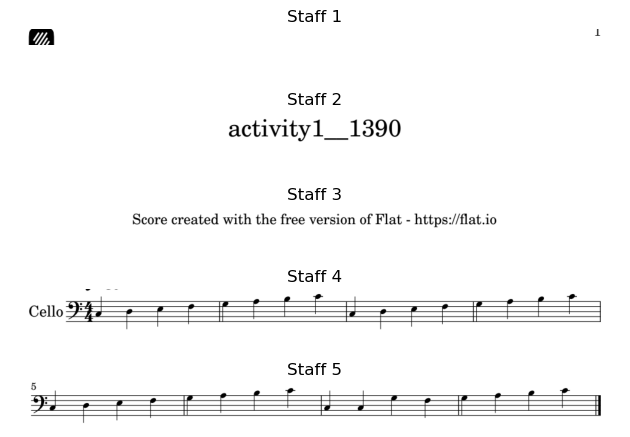

Found 2 potential large external objects.


<Figure size 640x480 with 0 Axes>

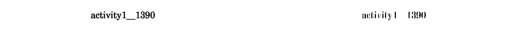

Found 30 potential large external objects.


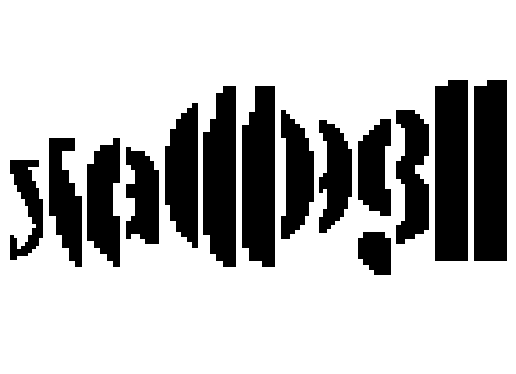

Found 84 potential large external objects.


<Figure size 640x480 with 0 Axes>

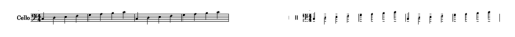

Found 75 potential large external objects.


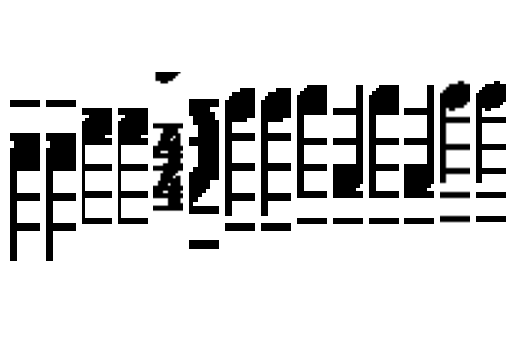

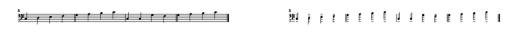

Found 51 potential large external objects.


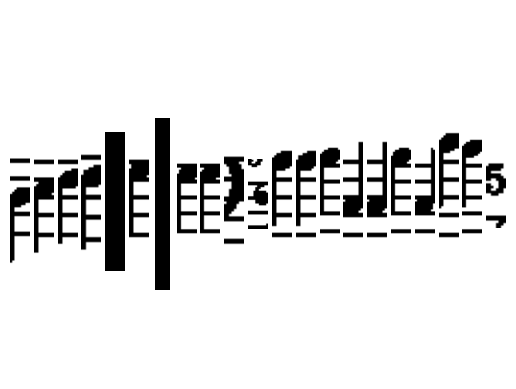

In [10]:
img = io.imread('ex1.png', as_gray=True)

staffs = segment_staff(img) # segments the sheet into individual staffs

fig, axes = plt.subplots(len(staffs), 1) 

axes = axes.flatten()
for i, staff in enumerate(staffs):
    axes[i].imshow(staff, cmap='gray') 
    axes[i].set_title(f'Staff {i+1}')
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

for staff_img in staffs:
    segments = staff_splicer(staff_img) # supposed to segment the staffs into individual notes...